# Convergence FEM / PINNs+Corr

**Remettre erreur en relative**

In [1]:
# sélection du cas test
testcase = 2
version = 2
param_num = 2
degree = 1
plot_result = False

In [2]:
assert testcase == 2 and version in [1, 2]
assert param_num <= 2
assert degree <= 3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
# from scimba.equations import domain
from modfenics.solver_fem.solver_fem_2_1D import FEMSolver
from testcases.utils import create_tree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [ ]:
if version == 1:
    from testcases.networks.test_1D.test_2.test_2_v1 import Run_laplacian1D,Poisson_1D
else:
    from testcases.networks.test_1D.test_2.test_2_v2 import Run_laplacian1D,Poisson_1D
from testcases.problem.problem_1D import TestCase2
problem = TestCase2()

result_dir = "../../results/test_1D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cuda


init
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe2_v2.pth
network loaded
Error  tensor([0.2299])


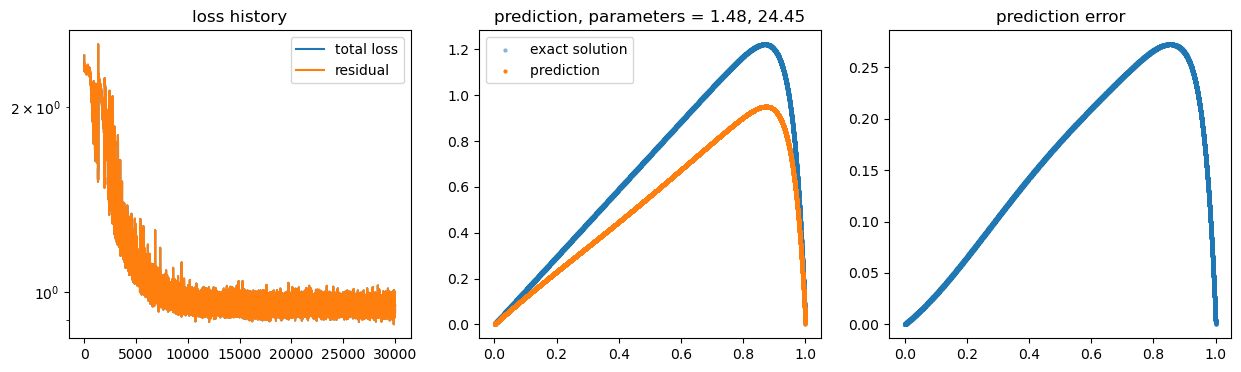

In [6]:
pde = Poisson_1D()
trainer,u_theta = Run_laplacian1D(pde)

In [7]:
test_params = [[1.2,40.0],[1.5,90.0]]
param = test_params[param_num-1]
print(f"param_num = {param_num}, param = {param}")
params = [param]

param_num = 2, param = [1.5, 90.0]


## Convergence FEM

In [8]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False,save_plots=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [10,20,40,80,160]#+[2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            filename=None
            if save_plots:
                filename = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}_nbvert{nb_vert}.png'            
            _,norme_L2 = solver.fem(0,plot_result=plot_result,filename=filename)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [9]:
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree,new_run=True,save_plots=True)

hmax =  0.11111111111111116
nb_vert=10, norme_L2=0.28997316919698857
hmax =  0.052631578947368474
nb_vert=20, norme_L2=0.11416647984572115
hmax =  0.02564102564102566
nb_vert=40, norme_L2=0.03611800111585853
hmax =  0.012658227848101333
nb_vert=80, norme_L2=0.00974267881163444
hmax =  0.0062893081761007386
nb_vert=160, norme_L2=0.0024737374919554305


## Convergence PINNs+Corr

In [10]:
def get_test_sample_fromV(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test

In [11]:
degree_PINNs = 10

def read_csv_Corr_Add(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr_Add(degree,new_run=False,save_plots=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr_Add(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [10,20,40,80,160]#[2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_Corr.append(solver.h)
            
            V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
            X_test,mu_test = get_test_sample_fromV(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            V_test = solver.V
            X_test,mu_test = get_test_sample_fromV(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild_inter = pred["w"][:,0].cpu().detach().numpy()
            u_PINNs_inter = df.Function(V_test)
            u_PINNs_inter.vector()[:] = phi_tild_inter.copy()
            
            filename=None
            if save_plots:
                filename = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}_nbvert{nb_vert}.png'
            _,_,norme_L2 = solver.corr_add(0,u_PINNs,u_PINNs_inter,plot_result=plot_result,filename=filename)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [12]:
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr_Add(degree,new_run=True,save_plots=True)

hmax =  0.11111111111111116
nb_vert=10, norme_L2=0.23102320030819304
hmax =  0.052631578947368474
nb_vert=20, norme_L2=0.09068640361914078
hmax =  0.02564102564102566
nb_vert=40, norme_L2=0.028672812100947104
hmax =  0.012658227848101333
nb_vert=80, norme_L2=0.007744265083449417
hmax =  0.0062893081761007386
nb_vert=160, norme_L2=0.0019687070585479222


In [13]:
degree_PINNs = 10

def read_csv_Corr_Mult(testcase,param_num,degree,M,type):
    df_Mult = pd.read_csv(result_dir+f'Mult_case{testcase}_param{param_num}_degree{degree}_M{M}_{type}.csv')
    tab_nb_vert_Mult = list(df_Mult['nb_vert'].values)
    tab_h_Mult = list(df_Mult['h'].values)
    tab_err_Mult = list(df_Mult['err'].values)
    
    return df_Mult,tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult

def run_Corr_Mult(degree,type="strong",new_run=False,save_plots=False):
    M = 0.0
    assert type in ["strong","weak"]
    csv_file = result_dir+f'Mult_case{testcase}_param{param_num}_degree{degree}_M{M}_{type}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Mult,tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult = read_csv_Corr_Mult(testcase,param_num,degree,M,type)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Mult = [10,20,40,80,160] #[2**i for i in range(4,9)]
        tab_h_Mult = []
        tab_err_Mult = []

        for nb_vert in tab_nb_vert_Mult:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            tab_h_Mult.append(solver.h)
            
            V_test = df.FunctionSpace(solver.mesh,"CG",degree_PINNs)
            X_test,mu_test = get_test_sample_fromV(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            u_PINNs = df.Function(V_test)
            u_PINNs.vector()[:] = phi_tild.copy()
            
            V_test = solver.V
            X_test,mu_test = get_test_sample_fromV(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild_inter = pred["w"][:,0].cpu().detach().numpy()
            u_PINNs_inter = df.Function(V_test)
            u_PINNs_inter.vector()[:] = phi_tild_inter.copy()
            
            filename = None
            if save_plots:
                filename = result_dir+f'Mult_case{testcase}_param{param_num}_degree{degree}_M{M}_{type}_nbvert{nb_vert}_{type}.png'
            _,_,norme_L2 = solver.corr_mult(0,u_PINNs,u_PINNs_inter,type=type,plot_result=plot_result,filename=filename)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Mult.append(norme_L2)
            
        df_Mult = pd.DataFrame({'nb_vert': tab_nb_vert_Mult, 'h': tab_h_Mult, 'err': tab_err_Mult})
        df_Mult.to_csv(csv_file, index=False)
            
    return df_Mult,tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult

In [14]:
print("## STRONG")
df_Mult_s,tab_nb_vert_Mult_s, tab_h_Mult_s, tab_err_Mult_s = run_Corr_Mult(degree,type="strong",new_run=True,save_plots=True)

## STRONG
hmax =  0.11111111111111116
nb_vert=10, norme_L2=0.22673812972940002
hmax =  0.052631578947368474


/home/flecourtier/Bureau/Article1/code/src/modfenics/solver_fem/solver_fem_2_1D.py:225: RuntimeWarning: divide by zero encountered in divide
  C_ex.vector()[:] = u_ex_inter.vector()[:]/phi_tild_inter.vector()[:]
/home/flecourtier/Bureau/Article1/code/src/modfenics/solver_fem/solver_fem_2_1D.py:225: RuntimeWarning: invalid value encountered in divide
  C_ex.vector()[:] = u_ex_inter.vector()[:]/phi_tild_inter.vector()[:]


nb_vert=20, norme_L2=0.09724666792926628
hmax =  0.02564102564102566
nb_vert=40, norme_L2=0.04481195383741296
hmax =  0.012658227848101333
nb_vert=80, norme_L2=0.02308191796721335
hmax =  0.0062893081761007386
nb_vert=160, norme_L2=0.012023440884645773


In [15]:
print("## WEAK")
df_Mult_w,tab_nb_vert_Mult_w, tab_h_Mult_w, tab_err_Mult_w = run_Corr_Mult(degree,type="weak",new_run=True,save_plots=True)

## WEAK
hmax =  0.11111111111111116
nb_vert=10, norme_L2=0.0019826245730909043
hmax =  0.052631578947368474
nb_vert=20, norme_L2=0.0004133306635235141
hmax =  0.02564102564102566
nb_vert=40, norme_L2=0.0004204497505374371
hmax =  0.012658227848101333
nb_vert=80, norme_L2=0.00012675525125621106
hmax =  0.0062893081761007386
nb_vert=160, norme_L2=5.352569561836108e-05


## Facteurs

In [16]:
tab_err_FEM = np.array(tab_err_FEM)
tab_err_Corr = np.array(tab_err_Corr)
tab_err_Mult_s = np.array(tab_err_Mult_s)
tab_err_Mult_w = np.array(tab_err_Mult_w)

facteurs_Add = tab_err_FEM/tab_err_Corr
print(facteurs_Add)
facteurs_Mult_s = tab_err_FEM/tab_err_Mult_s
print(facteurs_Mult_s)
facteurs_Mult_w = tab_err_FEM/tab_err_Mult_w
print(facteurs_Mult_w)

[1.25516904 1.25891507 1.25966023 1.25805079 1.25652899]
[1.27889019 1.1739886  0.80599032 0.42209139 0.20574289]
[146.25722546 276.21100954  85.90325258  76.86213167  46.21588684]


## Plots

Read csv file ../../results/test_1D/testcase2/version2/cvg/FEM_case2_param2_degree1.csv
Read csv file ../../results/test_1D/testcase2/version2/cvg/Corr_case2_param2_degree1.csv
Read csv file ../../results/test_1D/testcase2/version2/cvg/Mult_case2_param2_degree1_M0.0_strong.csv
Read csv file ../../results/test_1D/testcase2/version2/cvg/Mult_case2_param2_degree1_M0.0_weak.csv


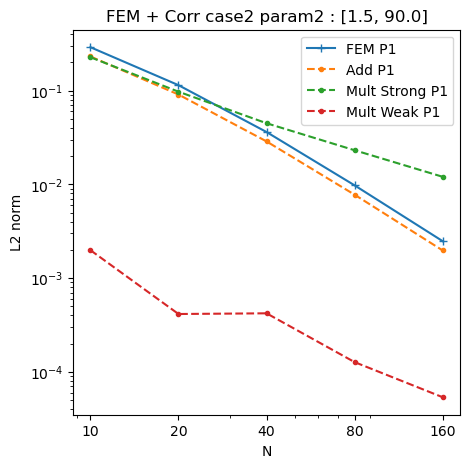

In [17]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)
plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(degree))

# plot Corr error (L2 norm) as a function of h
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr_Add(degree)
plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Add P'+str(degree))

# plot Corr error (L2 norm) as a function of h
df_Mult_s,tab_nb_vert_Mult_s, tab_h_Mult_s, tab_err_Mult_s = run_Corr_Mult(degree,type="strong")
plt.loglog(df_Mult_s['nb_vert'], df_Mult_s['err'], ".--", label='Mult Strong P'+str(degree))

# plot Corr error (L2 norm) as a function of h
df_Mult_w,tab_nb_vert_Mult_w, tab_h_Mult_w, tab_err_Mult_w = run_Corr_Mult(degree,type="weak")
plt.loglog(df_Mult_w['nb_vert'], df_Mult_w['err'], ".--", label='Mult Weak P'+str(degree))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')

In [18]:
# dataframe : classic, add, mult3, mult100
# error and facteurs, error and facteurs, error and facteurs, error and facteurs
# multiindex : error, facteurs

import pandas as pd

val = [tab_err_FEM, tab_err_Corr, facteurs_Add, tab_err_Mult_s, facteurs_Mult_s, tab_err_Mult_w, facteurs_Mult_w]

iterables = [("FEM","error"), ("Corr","error"), ("Corr","facteurs"), ("Mult_s","error"), ("Mult_s","facteurs"), ("Mult_w","error"), ("Mult_w","facteurs")]
index = pd.MultiIndex.from_tuples(iterables, names=["method", "type"])

df_final = pd.DataFrame(val, index=index, columns=tab_nb_vert_FEM).T

# Appliquer des formats spécifiques en fonction du type
def custom_formatting(df):
    # Appliquer un format spécifique pour les erreurs (notation scientifique)
    error_cols = df.columns[df.columns.get_level_values('type') == 'error']
    df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
    
    # Arrondir les facteurs à l'entier le plus proche
    factor_cols = df.columns[df.columns.get_level_values('type') == 'facteurs']
    # df[factor_cols] = df[factor_cols].applymap(lambda x: f'{int(round(x))}')
    df[factor_cols] = df[factor_cols].applymap(lambda x: f'{round(x,2)}')

    return df

# Appliquer la fonction de mise en forme
formatted_df = custom_formatting(df_final)

# Sauvegarder le DataFrame formaté au format CSV
formatted_df.to_csv(result_dir+f'Tab_case{testcase}_version{version}_param{param_num}_degree{degree}.csv')
# Et au format PNG
import dataframe_image as dfi
dfi.export(formatted_df, result_dir+f'Tab_case{testcase}_version{version}_param{param_num}_degree{degree}.png', dpi=300)

# Afficher le DataFrame formaté
formatted_df

/tmp/ipykernel_40558/1221031107.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/tmp/ipykernel_40558/1221031107.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{round(x,2)}')


method       FEM      Corr             Mult_s             Mult_w         
type       error     error facteurs     error facteurs     error facteurs
10      2.90e-01  2.31e-01     1.26  2.27e-01     1.28  1.98e-03   146.26
20      1.14e-01  9.07e-02     1.26  9.72e-02     1.17  4.13e-04   276.21
40      3.61e-02  2.87e-02     1.26  4.48e-02     0.81  4.20e-04     85.9
80      9.74e-03  7.74e-03     1.26  2.31e-02     0.42  1.27e-04    76.86
160     2.47e-03  1.97e-03     1.26  1.20e-02     0.21  5.35e-05    46.22